## Declaração de Funções e Classes Essenciais

Nesta seção, importamos as bibliotecas necessárias e definimos as classes e funções que formam a espinha dorsal do nosso framework de treinamento e avaliação de modelos. Isso inclui a definição de métricas de classificação, a estrutura para a validação cruzada (K-Folds) e a busca por hiperparâmetros (Grid Search).

In [ ]:
import numpy as np
import pandas as pd
from math import ceil
from sklearn.svm import SVC
from itertools import product
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from IPython.display import display
from abc import ABC, abstractmethod
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve,
    average_precision_score
)

### Cálculo de Métricas de Classificação

In [2]:
def evaluate_metrics(y_test: NDArray, y_predict: NDArray, y_predict_proba: NDArray):
    metrics = {
        'accuracy': accuracy_score(y_test, y_predict),
        'precision': precision_score(y_test, y_predict, zero_division=0),
        'recall': recall_score(y_test, y_predict, zero_division=0),
        'f1_score': f1_score(y_test, y_predict, zero_division=0),
        'auroc': roc_auc_score(y_test, y_predict_proba[:, 1]),
        'auprc': average_precision_score(y_test, y_predict_proba[:, 1])
    }
    return metrics

### Estrutura de Modelos e Treinadores
As classes a seguir definem uma estrutura para:
- **Model**: Uma classe base abstrata para modelos de machine learning.
- **KFoldTrainer**: Gerencia o treinamento de um modelo usando validação cruzada k-fold.
- **GridSearchTrainer**: Realiza uma busca em grid para encontrar os melhores hiperparâmetros para um modelo, utilizando o `KFoldTrainer`.
- **KFoldMultiModelsTrainer**: Orquestra o treinamento e avaliação de múltiplos modelos, cada um com sua própria busca de hiperparâmetros.

In [3]:
class Model(ABC):
    @abstractmethod
    def fit(self, X: NDArray, y: NDArray):
        pass

    @abstractmethod
    def predict(self, X: NDArray) -> NDArray:
        pass

    def predict_proba(self, X: NDArray) -> NDArray:
        pass

class KFoldTrainer:
    def __init__(self, k: int, dataset: NDArray, model: Model):
        self.k = k
        self.dataset = dataset
        self.model = model
        self.metrics = None

    def fit(self):
        metric_keys = ['accuracy', 'precision', 'recall', 'f1_score', 'auroc', 'auprc']
        metrics = {key: np.zeros(self.k) for key in metric_keys}

        for i, (X_train, y_train, X_validation, y_validation) in enumerate(self._generate_dataset_k_folds()):
            self.model.fit(X_train, y_train.ravel())
            y_predict = self.model.predict(X_validation)
            y_predict_proba = self.model.predict_proba(X_validation)

            metrics_i = evaluate_metrics(y_validation, y_predict, y_predict_proba)
            for key, value in metrics_i.items():
                metrics[key][i] = value

        self.metrics = {key: np.mean(value) for key, value in metrics.items()}

    def _generate_dataset_k_folds(self):
        np.random.shuffle(self.dataset)
        X, y = self.dataset[:, :-1], self.dataset[:, -1].astype(int).reshape((-1, 1))
        validation_size_percent = 1 / self.k

        n, _ = X.shape
        validation_size = ceil(n * validation_size_percent)
        for i in range(self.k):
            start, end = i * validation_size, (i + 1) * validation_size
            X_validation, y_validation = X[start:end], y[start:end]
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            yield X_train, y_train, X_validation, y_validation

class GridSearchTrainer:
    def __init__(self, k: int, dataset: NDArray, model_class: type[Model], hyper_params: dict[str, list]):
        self.k = k
        self.dataset = dataset
        self.model_class = model_class
        self.hyper_params = hyper_params

    def fit(self):
        params_names = list(self.hyper_params.keys())
        grid = list(product(*self.hyper_params.values()))
        best_accuracy = -1
        self.best_model = None
        self.best_hyper_params = None
        self.best_metrics = None

        for params_tuple in grid:
            params = dict(zip(params_names, params_tuple))
            model = self.model_class(**params, probability=True) if self.model_class == SVC else self.model_class(**params)

            k_fold_trainer = KFoldTrainer(self.k, self.dataset, model)
            k_fold_trainer.fit()
            accuracy = k_fold_trainer.metrics['accuracy']

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_metrics = k_fold_trainer.metrics
                self.best_model = model
                self.best_hyper_params = params

class KFoldMultiModelsTrainer(KFoldTrainer):
    def __init__(self, k: int, dataset: NDArray, models: dict[str, tuple[type[Model], dict[str, list]]]):
        self.k = k
        self.dataset = dataset
        self.models = models

    def fit(self):
        trained_models = {}
        metric_keys = ['accuracy', 'precision', 'recall', 'f1_score', 'auroc', 'auprc']

        for model_name, (model_class, hyper_params) in self.models.items():
            model_attributes = {
                'metrics_train': {metric: np.zeros(self.k) for metric in metric_keys},
                'metrics_test': {metric: np.zeros(self.k) for metric in metric_keys},
                'hyper_params': {param: np.zeros(self.k, dtype=object) for param in hyper_params.keys()},
                'model': np.zeros(self.k, dtype=object),
                'test_data': []
            }

            for i, (X_train, y_train, X_test, y_test) in enumerate(self._generate_dataset_k_folds()):
                dataset_train = np.c_[X_train, y_train]
                trainer = GridSearchTrainer(self.k, dataset_train, model_class, hyper_params)
                trainer.fit()

                y_predict = trainer.best_model.predict(X_test)
                y_predict_proba = trainer.best_model.predict_proba(X_test)
                test_metrics = evaluate_metrics(y_test, y_predict, y_predict_proba)

                for metric in metric_keys:
                    model_attributes['metrics_train'][metric][i] = trainer.best_metrics[metric]
                    model_attributes['metrics_test'][metric][i] = test_metrics[metric]

                for param in hyper_params.keys():
                    model_attributes['hyper_params'][param][i] = trainer.best_hyper_params[param]

                model_attributes['model'][i] = trainer.best_model
                model_attributes['test_data'].append((y_test, y_predict_proba))

            trained_models[model_name] = model_attributes
        return trained_models

### Funções Auxiliares de Plotagem

In [4]:
def extract_from_text(text: str):
    return float(text.split('%')[0])

def plot_models_metrics(trained_models: dict):
    metrics_data = {name: results['metrics_test'] for name, results in trained_models.items()}

    table_metrics = {model: {m: v for m, v in metrics.items() if m not in ['auroc', 'auprc']}
                     for model, metrics in metrics_data.items()}

    table = pd.DataFrame(table_metrics).T.map(lambda x: f"{np.mean(x):.2%} ± {1.96*np.std(x)/np.sqrt(len(x)):.2%}")
    table.columns = ['Acurácia', 'Precisão', 'Revocação', 'F1-Score']

    styled_table = table.style.apply(lambda col: ['font-weight:bold; color:red' if extract_from_text(x) == col.apply(extract_from_text).max() else '' for x in col])
    display(styled_table)

def plot_roc_pr_curves(trained_models: dict):
    for model_name, results in trained_models.items():
        best_run_idx = np.argmax(results['metrics_test']['accuracy'])
        y_test, y_predict_proba = results['test_data'][best_run_idx]

        fpr, tpr, _ = roc_curve(y_test, y_predict_proba[:, 1])
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(y_test, y_predict_proba[:, 1])
        pr_auc = average_precision_score(y_test, y_predict_proba[:, 1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'Curvas de Avaliação para o Melhor Modelo: {model_name}', fontsize=16)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('Taxa de Falsos Positivos')
        ax1.set_ylabel('Taxa de Verdadeiros Positivos')
        ax1.set_title('Curva ROC')
        ax1.legend(loc="lower right")

        ax2.plot(recall, precision, color='blue', lw=2, label=f'Curva PR (área = {pr_auc:.2f})')
        ax2.set_xlabel('Revocação (Recall)')
        ax2.set_ylabel('Precisão (Precision)')
        ax2.set_title('Curva Precision-Recall')
        ax2.legend(loc="lower left")

        plt.show()


# questão 01 -> items a,b

1. Lendo o dataset 'californiabin.csv'
2. Definindo os modelos SVM e Random Forest e hiperparâmetros para para fazer o grid search.
3. Treinamento dos modelos usando nested cv com 10 folds.
4. Plot das métricas e das curvas ROC e da Precision Recall

--- Métricas de Desempenho nos Dados de Teste (Média ± Intervalo de Confiança 95%) ---


,Acurácia,Precisão,Revocação,F1-Score
SVM (RBF),78.65% ± 2.83%,79.47% ± 1.65%,77.40% ± 4.17%,78.38% ± 2.54%
Random Forest,85.05% ± 0.65%,85.79% ± 2.18%,84.03% ± 1.33%,84.88% ± 0.93%



--- Melhores Hiperparâmetros e Métricas Detalhadas ---

Modelo: SVM (RBF)
  Melhores Hiperparâmetros encontrados: {'C': 8192, 'gamma': 3.0517578125e-05}
  AUROC Média: 0.8586
  AUPRC Média: 0.8466

Modelo: Random Forest
  Melhores Hiperparâmetros encontrados: {'n_estimators': 120, 'max_depth': None}
  AUROC Média: 0.9329
  AUPRC Média: 0.9345

--- Curvas de Avaliação para os Melhores Modelos de Cada Tipo ---


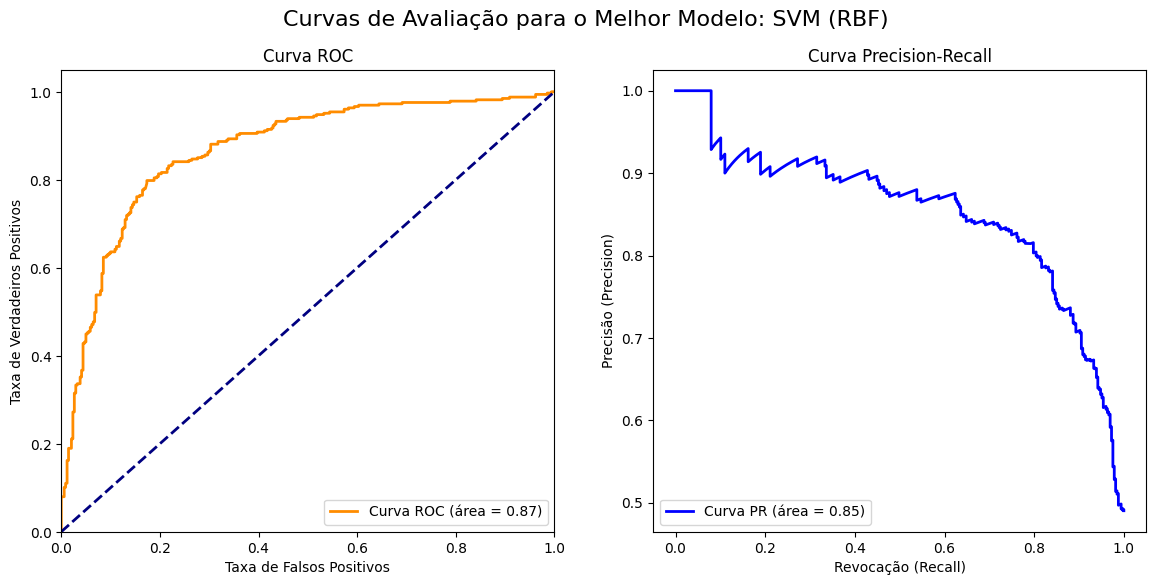

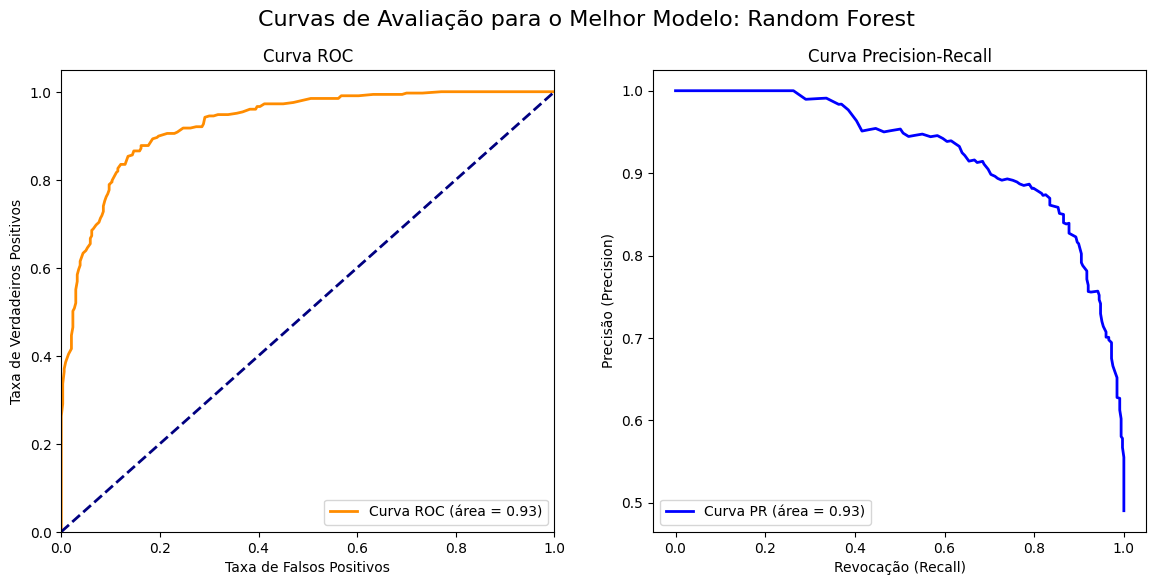

In [ ]:
dataset = np.genfromtxt('californiabin.csv', delimiter=',')

k = 10
np.random.seed(42)

models = {
    'SVM (RBF)': (
        SVC,
        {
            'C': [2**i for i in range(-5, 16, 2)],
            'gamma': [2**i for i in range(-15, 4, 2)]
        }
    ),
    'Random Forest': (
        RandomForestClassifier,
        {
            'n_estimators': list(range(10, 201, 10)),
            'max_depth': [4, 6, 8, 10, None]
        }
    )
}

trainer = KFoldMultiModelsTrainer(k, dataset, models)
trained_models = trainer.fit()

print("--- Métricas de Desempenho nos Dados de Teste (Média ± Intervalo de Confiança 95%) ---")
plot_models_metrics(trained_models)

print("\n--- Melhores Hiperparâmetros e Métricas Detalhadas ---")
for name, results in trained_models.items():
    print(f"\nModelo: {name}")
    best_run_idx = np.argmax(results['metrics_test']['accuracy'])
    best_params = {key: val[best_run_idx] for key, val in results['hyper_params'].items()}
    print(f"  Melhores Hiperparâmetros encontrados: {best_params}")

    auroc_mean = np.mean(results['metrics_test']['auroc'])
    auprc_mean = np.mean(results['metrics_test']['auprc'])
    print(f"  AUROC Média: {auroc_mean:.4f}")
    print(f"  AUPRC Média: {auprc_mean:.4f}")

print("\n--- Curvas de Avaliação para os Melhores Modelos de Cada Tipo ---")
plot_roc_pr_curves(trained_models)
